In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import scipy.ndimage as ndimage
from skimage.transform import resize

import GOES
import pyproj as pyproj
from pyresample import utils
from pyresample.geometry import SwathDefinition
from pyresample.kd_tree import resample_nearest
import concurrent.futures

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Layer, UpSampling2D, BatchNormalization, SpatialDropout2D, Activation, Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, add, multiply, dot
from tensorflow.keras.models import Model

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import datetime
import concurrent.futures

2024-07-14 06:42:03.037873: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from concurrent.futures import ThreadPoolExecutor, as_completed

In [4]:
import psutil

# Get the number of logical CPUs (threads)
num_threads = psutil.cpu_count()
print(f"Number of CPU threads available: {num_threads}")

os.environ["OMP_NUM_THREADS"] = str(num_threads)
os.environ["TF_NUM_INTRAOP_THREADS"] = str(num_threads)
os.environ["TF_NUM_INTEROP_THREADS"] = str(num_threads)

tf.config.threading.set_inter_op_parallelism_threads(
    num_threads
)
tf.config.threading.set_intra_op_parallelism_threads(
    num_threads
)
tf.config.set_soft_device_placement(True)

Number of CPU threads available: 40


In [5]:
root_dir = '/home/ayadav7/'
data_dir = os.path.join(root_dir, 'data')

In [6]:
train_data_files = os.listdir(os.path.join(root_dir, 'scaled_data'))

In [7]:
# Separate the lists into X and y files
x_files = [f for f in train_data_files if f.startswith('X_')]
y_files = [f for f in train_data_files if f.startswith('y_')]

# Extract the common parts of the filenames for comparison
x_keys = {f.split('X_')[1].split('.nc.npy')[0] for f in x_files}
y_keys = {f.split('y_')[1].split('.nc.npy')[0] for f in y_files}

# Find missing X files for y files
missing_x = y_keys - x_keys

# Find missing y files for X files
missing_y = x_keys - y_keys

# Print results
if missing_x:
    print(f'Missing X files for y files: {missing_x}')
else:
    print('No missing X files for y files.')

if missing_y:
    print(f'Missing y files for X files: {missing_y}')
else:
    print('No missing y files for X files.')

No missing X files for y files.
Missing y files for X files: {'2019_139_18_g17', '2019_146_12_g17', '2019_144_0_g17', '2019_142_6_g17', '2019_156_0_g17'}


In [8]:
# Find the common keys
common_keys = x_keys & y_keys

# Filter the file list to include only matched files
filtered_file_list = [f for f in train_data_files if any(key in f for key in common_keys)]

print(f'Filtered file list: {len(filtered_file_list)}')

Filtered file list: 178


In [9]:
x_files = [f for f in filtered_file_list if f.startswith('X_')]
y_files = [f for f in filtered_file_list if f.startswith('y_')]

x_files.sort()
y_files.sort()

In [10]:
x_files = x_files[1:]
y_files = y_files[1:]

In [11]:
# Function to normalize data using min-max normalization
def min_max_normalize_channel_wise(data):
    normalized_data = np.empty_like(data)
    num_channels = data.shape[-1]
    for i in range(num_channels):
        min_val = np.min(data[..., i])
        max_val = np.max(data[..., i])
        normalized_data[..., i] = (data[..., i] - min_val) / (max_val - min_val)
    return normalized_data

In [12]:
# # Function to process a single file
# def process_file(i):
#     print(f'processing {i}')
#     x_file = x_files[i]
#     y_file = y_files[i]

#     X = np.nan_to_num(np.load(os.path.join(root_dir, 'preprocessed_data', x_file)), nan=0.0)
#     y = np.load(os.path.join(root_dir, 'preprocessed_data', y_file))

#     # Normalize each channel separately
#     X = min_max_normalize_channel_wise(X)

#     np.save(os.path.join(root_dir, 'scaled_data', x_files[i]), X)
#     np.save(os.path.join(root_dir, 'scaled_data', y_files[i]), y)
#     print(f'processing {i} done')

# # Parallel processing using ThreadPoolExecutor
# print("Transforming and saving data using parallel processing...")
# with ThreadPoolExecutor(max_workers=40) as executor:
#     futures = [executor.submit(process_file, i) for i in range(len(x_files))]
#     for future in tqdm(as_completed(futures), total=len(futures)):
#         future.result()  # Ensure any exceptions are raised

# print("Transformation and saving complete.")

## Models

In [13]:
class BatchedDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_filenames, y_filenames, batch_size=1, shuffle=True):
        self.x_filenames = x_filenames
        self.y_filenames = y_filenames
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        # Return the number of batches per epoch
        return int(np.floor(len(self.x_filenames) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(batch_indexes)

        return X, y

    def on_epoch_end(self):
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.x_filenames))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_indexes):
        # Initialization
        X = []
        y = []

        # Generate data
        for i in batch_indexes:
            # Load sample
            x = np.nan_to_num(np.load(self.x_filenames[i]), nan=0.0)
            y_sample = np.load(self.y_filenames[i])

            X.append(x)
            y.append(y_sample)

        # Concatenate the list of arrays to get a batch of size (batch_size * 30, 896, 896, 18) and (batch_size * 30, 896, 896, 1)
        return np.concatenate(X, axis=0), np.concatenate(y, axis=0)

In [14]:
input_shape = (896, 896, 18)  # Replace with your actual input shape
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 896, 896, 16)      2608      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 448, 448, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 448, 448, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 224, 224, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0

2024-07-14 06:42:15.334711: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
input_shape = (896, 896, 18)  
def small_unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder: contracting path
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    
    # Decoder: expanding path
    u5 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)
    
    u6 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    
    return model

model = small_unet_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 896, 896, 1  0           []                               
                                8)]                                                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 896, 896, 32  5216        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 896, 896, 32  9248        ['conv2d_5[0][0]']               
                                )                                                             

In [16]:
x_filepaths = [os.path.join(root_dir,'scaled_data',xf) for xf in x_files]
y_filepaths = [os.path.join(root_dir,'scaled_data',yf) for yf in y_files]

x_filepaths = x_filepaths[1:40]
y_filepaths = y_filepaths[1:40]

In [17]:
batch_size = 1
data_generator = BatchedDataGenerator(x_filepaths, y_filepaths, batch_size=batch_size)

In [18]:
# X, y = data_generator[0]
# print(X.shape, y.shape)

In [19]:
# fig, ax = plt.subplots(5,12,figsize=(12,6))

# k1 = 0
# k2 = 0
# for i in range(5):
#     for j in range(6):
#         ax[i,j].imshow(X[k1,:,:,7])
#         k1 = k1 + 1
#         ax[i,j].axis('off')

#     for j in range(6,12):
#         ax[i,j].imshow(y[k2,:,:,0])
#         k2 = k2 + 1
#         ax[i,j].axis('off')
# plt.show()

# fig, ax = plt.subplots(1,1,figsize=(3,1.5))
# ax.imshow(X[0,:,:,16])
# plt.show()

In [20]:
model.fit(data_generator, epochs=5)

Epoch 1/5
39/39 [==============================] - 1900s 49s/step - loss: 0.3057 - accuracy: 0.4446
Epoch 2/5
39/39 [==============================] - 1895s 48s/step - loss: 0.2640 - accuracy: 0.4449
Epoch 3/5
39/39 [==============================] - 1897s 49s/step - loss: 0.2546 - accuracy: 0.4449
Epoch 4/5
39/39 [==============================] - 1894s 48s/step - loss: 0.2537 - accuracy: 0.4449
Epoch 5/5
39/39 [==============================] - 1891s 48s/step - loss: 0.2542 - accuracy: 0.4449


In [21]:
model.save('cnn_model.h5')

In [22]:
model = tf.keras.models.load_model('cnn_model.h5')

In [24]:
predictions = model.predict(data_generator)
print("Predictions shape:", predictions.shape)

39/39 [==============================] - 231s 6s/step
Predictions shape: (1170, 896, 896, 1)


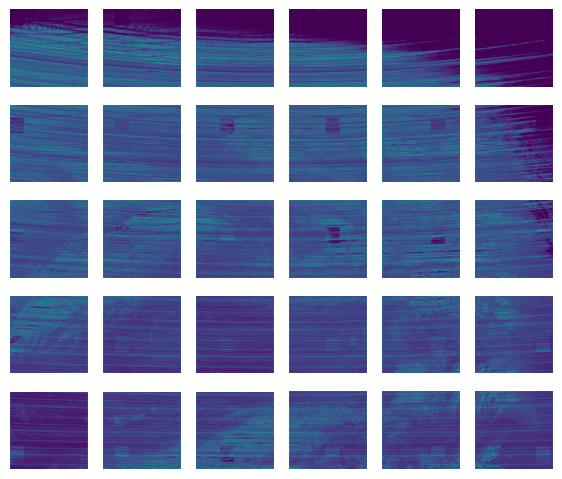

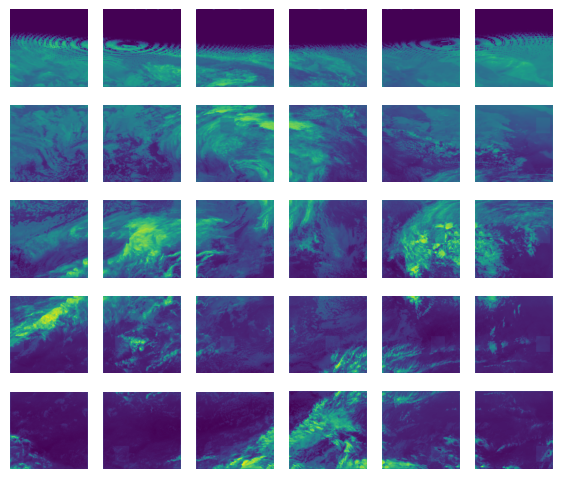

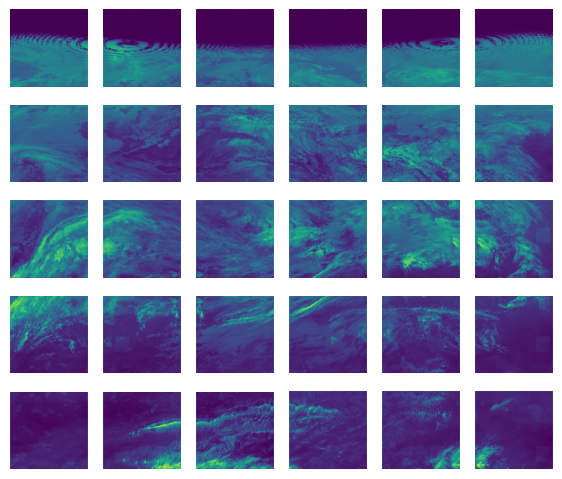

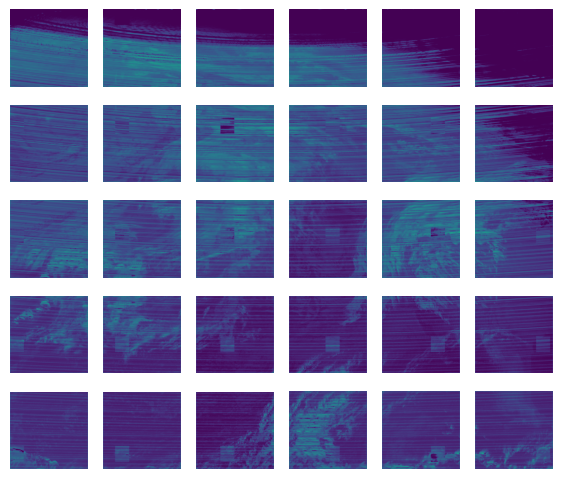

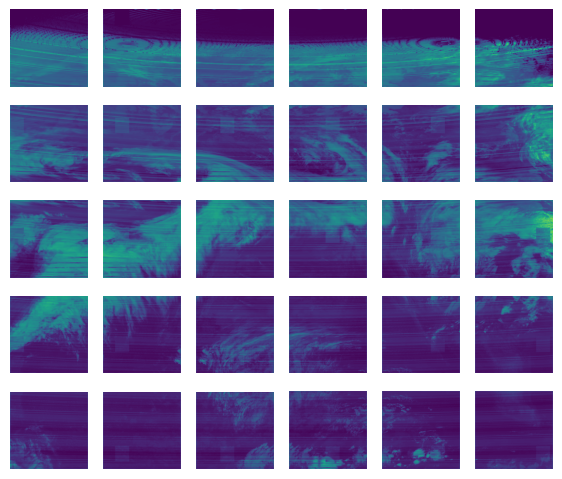

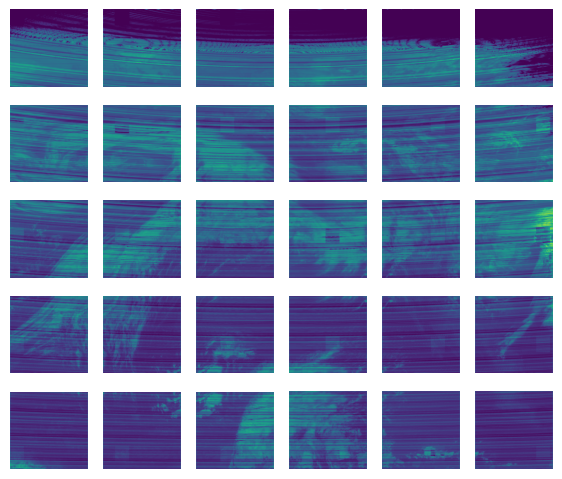

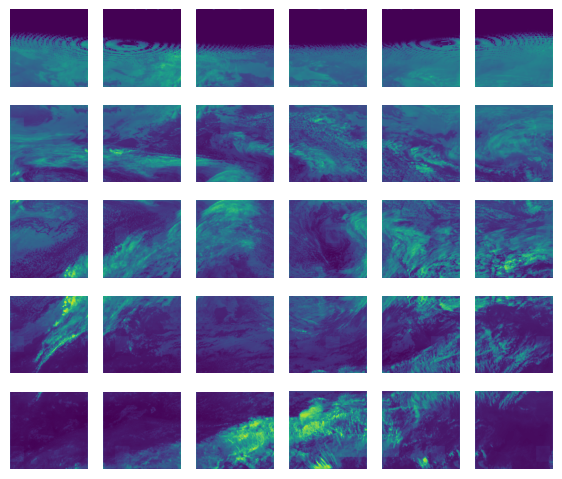

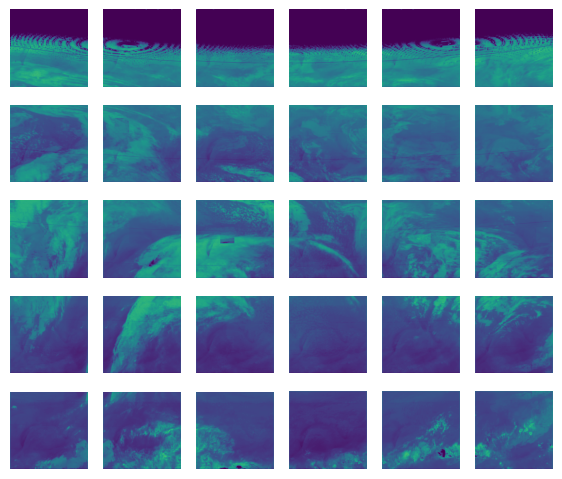

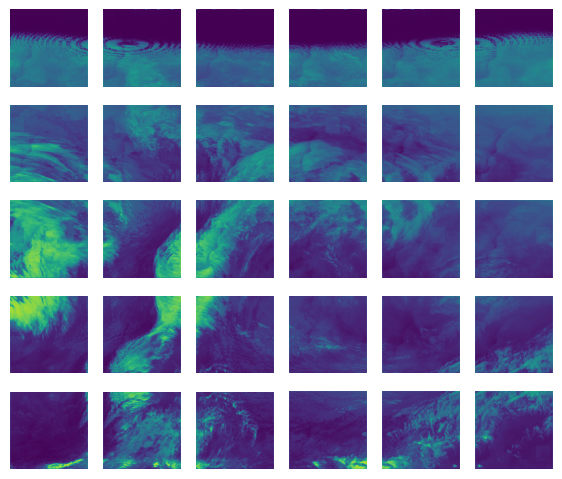

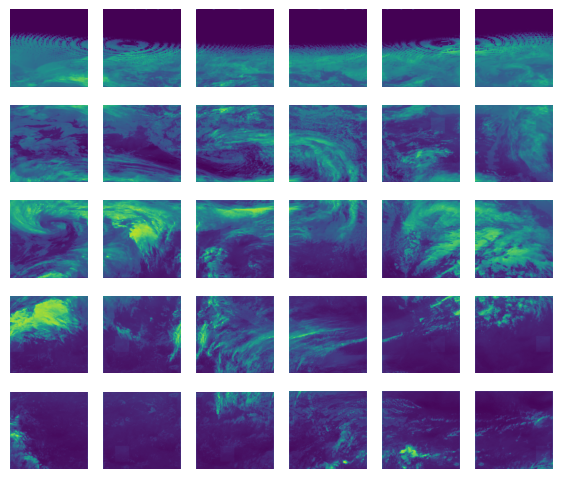

In [28]:
k1 = 0
for k in range(10):
    fig, ax = plt.subplots(5,6,figsize=(7,6))
    for i in range(5):
        for j in range(6):
            ax[i,j].imshow(predictions[k1,:,:,0])
            k1 = k1 + 1
            ax[i,j].axis('off')
    plt.show()

# fig, ax = plt.subplots(5,6,figsize=(7,6))
# for i in range(5):
#     for j in range(6):
#         ax[i,j].imshow(predictions[k1,:,:,0])
#         k1 = k1 + 1
#         ax[i,j].axis('off')
# plt.show()

(array([1.59348867e+08, 2.90577297e+08, 2.30370038e+08, 1.54953656e+08,
        6.76606180e+07, 2.46802070e+07, 8.59431600e+06, 2.67549000e+06,
        4.28084000e+05, 6.14700000e+03]),
 array([0.        , 0.04320103, 0.08640205, 0.12960307, 0.1728041 ,
        0.21600513, 0.25920615, 0.30240718, 0.3456082 , 0.38880923,
        0.43201026]),
 <BarContainer object of 10 artists>)

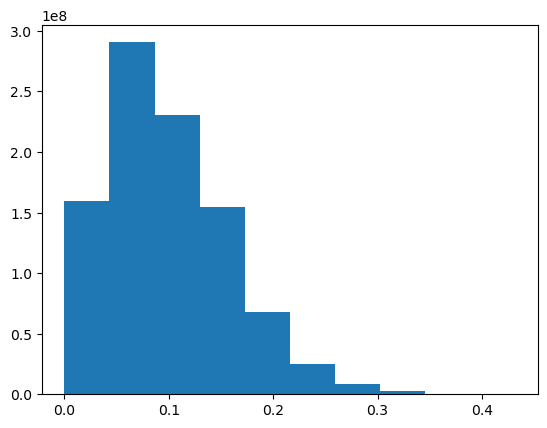

In [26]:
plt.hist(predictions.flatten())

In [10]:
# List all available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
print(f"Number of GPUs available: {len(gpus)}")

# Print GPU details
for gpu in gpus:
    print(f"GPU: {gpu}")

# Enable memory growth for each GPU to avoid TensorFlow from allocating all memory on the GPU
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Check if TensorFlow is using the GPUs
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(f"Number of logical GPUs: {len(logical_gpus)}")

# Example of setting GPU usage (if needed)
# Uncomment the following lines if you want to restrict TensorFlow to use specific GPUs
# gpus_to_use = [0, 1]  # Example: Use only the first two GPUs
# tf.config.experimental.set_visible_devices([gpus[i] for i in gpus_to_use], 'GPU')

# Confirm GPU usage by running a simple computation
with tf.device('/GPU:0'):
    a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
    b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
    c = tf.matmul(a, b)
    print(c)

Number of GPUs available: 0
Number of logical GPUs: 0
tf.Tensor(
[[1. 3.]
 [3. 7.]], shape=(2, 2), dtype=float32)


In [1]:
import os
import psutil

# Get the number of logical CPUs (threads)
num_threads = psutil.cpu_count()
print(f"Number of CPU threads available: {num_threads}")

# Set environment variables before importing TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow logging
os.environ['OMP_NUM_THREADS'] = str(num_threads)  # Adjust to the number of CPU threads

import tensorflow as tf

# Set the number of threads for intra-op and inter-op parallelism
tf.config.threading.set_intra_op_parallelism_threads(num_threads)
tf.config.threading.set_inter_op_parallelism_threads(num_threads)

# List all available CPUs
physical_cpus = tf.config.experimental.list_physical_devices('CPU')
print(f"Number of CPUs available: {len(physical_cpus)}")

# Ensure TensorFlow is using the CPUs
logical_cpus = tf.config.experimental.list_logical_devices('CPU')
print(f"Number of logical CPUs: {len(logical_cpus)}")

# Confirm CPU usage by running a simple computation
with tf.device('/CPU:0'):
    a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
    b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
    c = tf.matmul(a, b)
    print(c)

# Configure MultiWorkerMirroredStrategy for CPU training
strategy = tf.distribute.MultiWorkerMirroredStrategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")

Number of CPU threads available: 40
Number of CPUs available: 1
Number of logical CPUs: 1
tf.Tensor(
[[1. 3.]
 [3. 7.]], shape=(2, 2), dtype=float32)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.AUTO
Number of devices: 1


In [12]:
# Set environment variables (optional)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow logging
os.environ['OMP_NUM_THREADS'] = '40'  # Adjust to the number of CPU threads you have

# List all available CPUs
physical_cpus = tf.config.experimental.list_physical_devices('CPU')
print(f"Number of CPUs available: {len(physical_cpus)}")

# Ensure TensorFlow is using the CPUs
logical_cpus = tf.config.experimental.list_logical_devices('CPU')
print(f"Number of logical CPUs: {len(logical_cpus)}")

# Confirm CPU usage by running a simple computation
with tf.device('/CPU:0'):
    a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
    b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
    c = tf.matmul(a, b)
    print(c)

# Configure MultiWorkerMirroredStrategy for CPU training
strategy = tf.distribute.MultiWorkerMirroredStrategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")

Number of CPUs available: 1
Number of logical CPUs: 1
tf.Tensor(
[[1. 3.]
 [3. 7.]], shape=(2, 2), dtype=float32)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.AUTO
Number of devices: 1


In [21]:
# Define a simple model to test multi-CPU usage
with strategy.scope():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(896, 896, 18)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# Create a dummy data generator to test the setup
class DummyDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_size=1):
        self.batch_size = batch_size
        self.x = np.random.rand(batch_size, 896, 896, 18).astype(np.float32)
        self.y = np.random.rand(batch_size, 896, 896, 1).astype(np.float32)

    def __len__(self):
        return 1  # Only one batch for testing

    def __getitem__(self, index):
        return self.x, self.y

# Create a dummy data generator instance
dummy_data_generator = DummyDataGenerator(batch_size=1)

# Fit the model using the dummy data generator
model.fit(dummy_data_generator, epochs=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 896, 896, 32)      5216      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 448, 448, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 448, 448, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 224, 224, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 128)     73856     
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 448, 448, 64)    

2024-07-14 03:40:06.885434: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\017TensorDataset:5"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



1/1 [==============================] - 4s 4s/step - loss: 0.6932 - accuracy: 0.0000e+00
